# Experiment: Estimating the Willingness to Pay using LLMs

In [290]:
import random
from concurrent.futures import ThreadPoolExecutor
from itertools import combinations, product

import dotenv
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from langchain.chat_models import AzureChatOpenAI
from langchain_core.prompts import PromptTemplate
from matplotlib import pyplot as plt
from tqdm import tqdm

dotenv.load_dotenv("../.env")


llm = AzureChatOpenAI(
    azure_deployment="emi-gpt-4o-mini",
    temperature=1.0,  # as per the paper
    max_tokens=200,
    # logprobs=True,
)

Define the attributes of the product as follows:

In [ ]:
incomes = [30000, 100000]
flavors = ["mint", "cinnamon"]
prices = [1.99, 2.39, 2.79, 3.19, 3.59]
brands = ["Colgate"]  # fixed brand for simplicity

In [65]:
product_configurations = [
    {"flavor": flavor, "price": price, "brand": brand}
    for flavor, price, brand in product(flavors, prices, brands)
]
pd.DataFrame(product_configurations)

,flavor,price,brand
0,mint,1.99,Colgate
1,mint,2.39,Colgate
2,mint,2.79,Colgate
3,mint,3.19,Colgate
4,mint,3.59,Colgate
5,cinnamon,1.99,Colgate
6,cinnamon,2.39,Colgate
7,cinnamon,2.79,Colgate
8,cinnamon,3.19,Colgate
9,cinnamon,3.59,Colgate


In [ ]:
SYSTEM_TEMPLATE = PromptTemplate.from_template("""
You are a customer with an annual income of ${income}. You are selected at random while shopping for toothpaste to participate in a survey.
The interviewer will describe the options you saw while shopping and ask you to report which option you chose to purchase.
Whenever two options are shown, you can also choose a third option which is not to purchase anything that day.
""".strip())

USER_TEMPLATE = PromptTemplate.from_template("""
While shopping, you see two options:
1. {option1[brand]} toothpaste, flavor: {option1[flavor]}, price: ${option1[price]:.2f}
2. {option2[brand]} toothpaste, flavor: {option2[flavor]}, price: ${option2[price]:.2f}
You also have the option not to purchase toothpaste.
Did you purchase either of the available toothpaste options? If so, which one?
Provide the selected option # first (1, 2 or 3), then provide a brief explanation of why you chose that option.
""".strip())

# Mention the number of the option you chose first, then provide a brief explanation of why you chose that option.

Example of the prompt.

In [307]:
print(SYSTEM_TEMPLATE.format(income=30000), end="\n\n")
print(USER_TEMPLATE.format(option1=product_configurations[0], option2=product_configurations[1]))

You are a customer with an annual income of $30000. You are selected at random while shopping for toothpaste to participate in a survey.
The interviewer will describe the options you saw while shopping and ask you to report which option you chose to purchase.
Whenever two options are shown, you can also choose a third option which is not to purchase anything that day.

While shopping, you see two options:
1. Colgate toothpaste, flavor: mint, price: $1.99
2. Colgate toothpaste, flavor: mint, price: $2.39
You also have the option not to purchase toothpaste.
Did you purchase either of the available toothpaste options? If so, which one?
Provide the selected option # first (1, 2 or 3), then provide a brief explanation of why you chose that option.


Generate all combinations for the conjoint sets (in a simple manner)

In [271]:
pairs = [
    {
        "income": income,
        "option1": option1,
        "option2": option2,
    }
    for income in incomes
    for option1, option2 in product(product_configurations, product_configurations)
    for _ in range(10)
    if (option1["flavor"], option1["brand"]) != (option2["flavor"], option2["brand"])
]
len(pairs)

1000

### Execute the prompts

In [273]:
def run_prompt(messages):
    response = llm.invoke(messages)
    total_tokens = response.response_metadata["token_usage"]["total_tokens"]
    return {
        "response": response.content,
        "total_tokens": total_tokens,
    }

In [274]:
with ThreadPoolExecutor(max_workers=40) as executor:
    results = executor.map(
        run_prompt,
        [
            [
                ("system", SYSTEM_TEMPLATE.format(**pair)),
                ("user", USER_TEMPLATE.format(**pair)),
            ]
            for pair in pairs
        ],
    )

results = list(tqdm(results, total=len(pairs)))
# results

100%|██████████| 1000/1000 [00:00<00:00, 128754.42it/s]


In [330]:
random.choice(results)

{'response': '1. I chose option 1, the Colgate toothpaste in cinnamon flavor priced at $1.99. Given my annual income, I prefer to save money where I can, and the cinnamon flavor was the cheaper option, which appealed to me.',
 'total_tokens': 229}

### Interpret the results

In [317]:
df_option1 = pd.DataFrame([p["option1"] for p in pairs])
df_option2 = pd.DataFrame([p["option2"] for p in pairs])
df_income = pd.DataFrame([p["income"] for p in pairs], columns=["income"])
df_results = pd.DataFrame(results)

df_merged = pd.merge(df_option1, df_option2, left_index=True, right_index=True)
df_merged = pd.merge(df_merged, df_income, left_index=True, right_index=True)
df_merged = pd.merge(df_merged, df_results, left_index=True, right_index=True)
df_merged.sample(5)

,flavor_x,price_x,brand_x,flavor_y,price_y,brand_y,income,response,total_tokens
71,mint,2.39,Colgate,cinnamon,2.79,Colgate,30000,"1. I chose option 1, the Colgate toothpaste in...",250
768,cinnamon,1.99,Colgate,mint,2.39,Colgate,100000,I chose option 1. \n\nI purchased the Colgate ...,232
848,cinnamon,2.39,Colgate,mint,3.59,Colgate,100000,"1. I chose option 1, the Colgate toothpaste in...",241
726,mint,3.59,Colgate,cinnamon,2.79,Colgate,100000,2. I chose the cinnamon-flavored Colgate tooth...,225
173,mint,3.19,Colgate,cinnamon,2.79,Colgate,30000,I chose option 2. I decided to purchase the Co...,234


### Total cost

In [318]:
total_tokens = df_merged.total_tokens.sum()
print(f"Tokens used: {total_tokens}")
print(f"Cost: ${total_tokens * 1.5e-7:.4f}")

Tokens used: 233349
Cost: $0.0350


### A/B balance

In [319]:
df_merged["choice"] = df_merged["response"].str.extract("(?:[Oo]ption|number|^)\s*(\d)")
print(df_merged["choice"].value_counts(dropna=False))
df_merged = df_merged[df_merged["choice"].isin(["1", "2"])]
df_merged["choice"] = df_merged["choice"].astype(int)

choice
1    620
2    375
3      5
Name: count, dtype: int64


In [320]:
df_counts = df_merged.groupby(
    ["income", "flavor_x", "flavor_y", "price_x", "price_y", "choice"]
).size().unstack().fillna(0).astype(int).rename(columns={1: "A", 2: "B"}).reset_index()

# flip A/B if flavor_x > flavor_y
flip_mask = df_counts["flavor_x"] > df_counts["flavor_y"]
df_counts.loc[flip_mask, ["flavor_x", "flavor_y", "price_x", "price_y", "A", "B"]] = \
    df_counts.loc[flip_mask, ["flavor_y", "flavor_x", "price_y", "price_x", "B", "A"]].values
df_counts = df_counts.groupby(["income", "flavor_x", "flavor_y", "price_x", "price_y"]).sum().reset_index()

# df_counts

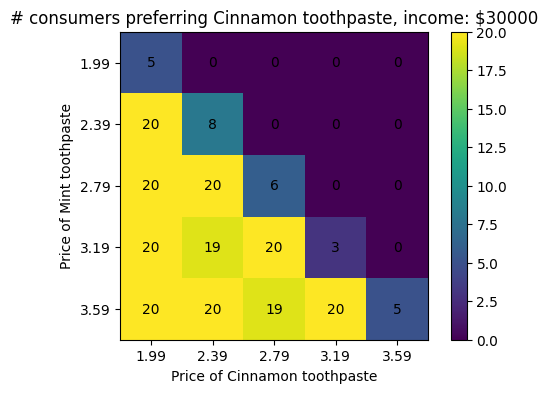

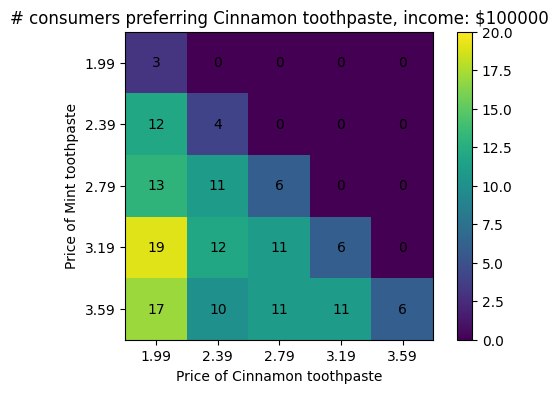

In [340]:
for income, df_income in df_counts.groupby("income"):
    plt.figure(figsize=(6, 4))
    plt.title(f"# consumers preferring Cinnamon toothpaste, income: ${income}")
    heatmap_data = df_income.pivot(columns="price_x", index="price_y", values="A")
    plt.imshow(heatmap_data, cmap=None, vmin=0, vmax=20)
    plt.colorbar()
    plt.xlabel("Price of Cinnamon toothpaste")
    plt.ylabel("Price of Mint toothpaste")
    plt.xticks(range(len(prices)), prices)
    plt.yticks(range(len(prices)), prices)
    for i in range(len(prices)):
        for j in range(len(prices)):
            plt.text(j, i, f"{heatmap_data.iloc[i, j]}", ha="center", va="center", color="black")
    plt.show()

## Model

In [322]:
flavor_map = {"mint": 1.0, "cinnamon": 0.0}
df_merged["flavor_diff"] = df_merged["flavor_x"].map(flavor_map) - df_merged["flavor_y"].map(flavor_map)
df_merged["price_diff"] = df_merged["price_x"] - df_merged["price_y"]
df_merged["choice_binary"] = (df_merged["choice"] == 2).astype(int)

In [323]:
model = smf.logit(
    "choice_binary ~ flavor_diff + price_diff",
    data=df_merged[df_merged.income == 30000],
).fit()

print(model.summary())

params = model.params
beta_flavor = params["flavor_diff"]
beta_price = params["price_diff"]

WTP_flavor = -beta_flavor / beta_price
print(f"\nWillingness-to-Pay for flavor (mint vs cinnamon): ${WTP_flavor:.3f}")

Optimization terminated successfully.
         Current function value: 0.104985
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:          choice_binary   No. Observations:                  495
Model:                          Logit   Df Residuals:                      492
Method:                           MLE   Df Model:                            2
Date:                Thu, 19 Dec 2024   Pseudo R-squ.:                  0.8475
Time:                        13:35:44   Log-Likelihood:                -51.968
converged:                       True   LL-Null:                       -340.68
Covariance Type:            nonrobust   LLR p-value:                4.116e-126
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -1.4719      0.331     -4.443      0.000      -2.121      -0.823
flavor_diff    -1.3464   

In [324]:
model = smf.logit(
    "choice_binary ~ flavor_diff + price_diff",
    data=df_merged[df_merged.income == 100000],
).fit()

print(model.summary())

params = model.params
beta_flavor = params["flavor_diff"]
beta_price = params["price_diff"]

WTP_flavor = -beta_flavor / beta_price
print(f"\nWillingness-to-Pay for flavor (mint vs cinnamon): ${WTP_flavor:.3f}")

Optimization terminated successfully.
         Current function value: 0.206159
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:          choice_binary   No. Observations:                  500
Model:                          Logit   Df Residuals:                      497
Method:                           MLE   Df Model:                            2
Date:                Thu, 19 Dec 2024   Pseudo R-squ.:                  0.6644
Time:                        13:35:45   Log-Likelihood:                -103.08
converged:                       True   LL-Null:                       -307.11
Covariance Type:            nonrobust   LLR p-value:                 2.464e-89
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -2.9063      0.337     -8.618      0.000      -3.567      -2.245
flavor_diff    -2.9063    